In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append(os.getcwd()+"/../../")

import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from ood_detection_helper import *

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
sns.set(style="darkgrid")

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.__version__

Num GPUs Available:  0
[]


'2.3.1'

## Loading OOD datasets

In [3]:
with open("train_scores_ckpt-last.p", "rb") as f:
    train_scores = pickle.load(f)
print(train_scores.shape)

with open("scores_ckpt-last.p", "rb") as f:
    inlier_scores = pickle.load(f).numpy()
inlier_scores.shape

(73000, 10)


(26000, 10)

In [4]:
with open("ood_scores_ckpt-last.p", "rb") as f:
    ood_dict = pickle.load(f)
ood_dict.keys()

dict_keys(['LSUN', 'LSUN_resize', 'Imagenet', 'Imagenet_resize', 'iSUN', 'gaussian', 'uniform', 'cifar'])

In [5]:
outlier_scores = [x.numpy() for x in ood_dict.values()]
non_synthetic_images = ['LSUN','LSUN_resize', 'Imagenet', 'Imagenet_resize', 'iSUN']
outlier_scores.append(np.concatenate([ood_dict[n].numpy() for n in non_synthetic_images]))

In [6]:
ood_names = list(ood_dict.keys()) + ["All Images"]
ood_names, len(outlier_scores)

(['LSUN',
  'LSUN_resize',
  'Imagenet',
  'Imagenet_resize',
  'iSUN',
  'gaussian',
  'uniform',
  'cifar',
  'All Images'],
 9)

## Calculating Scores

In [7]:
LABELS = np.array(["Train", "SVHN", 'LSUN','LSUN_resize',
                   'Imagenet','Imagenet_resize','iSUN',"Gaussian", "Uniform", "CIFAR", "All Images"])
COLORS = sns.color_palette("bright")

In [41]:
all_samples = np.concatenate([inlier_scores, *outlier_scores[:-4]])

all_labels = [0] * len(inlier_scores)

for idx, ood in enumerate(outlier_scores[:-4]): #Skipping gauss and uniform
    all_labels += [idx+1]*len(ood)

captions = [LABELS[x+1] for x in all_labels]

all_samples.shape, len(all_labels), len(captions)

((74925, 10), 74925, 74925)

In [42]:
%%time
import umap

umapper = umap.UMAP(n_components = 3,
                    n_neighbors=15,
                    min_dist=0)

embedding = umapper.fit_transform(all_samples)


CPU times: user 24min 45s, sys: 3min 18s, total: 28min 4s
Wall time: 56.9 s


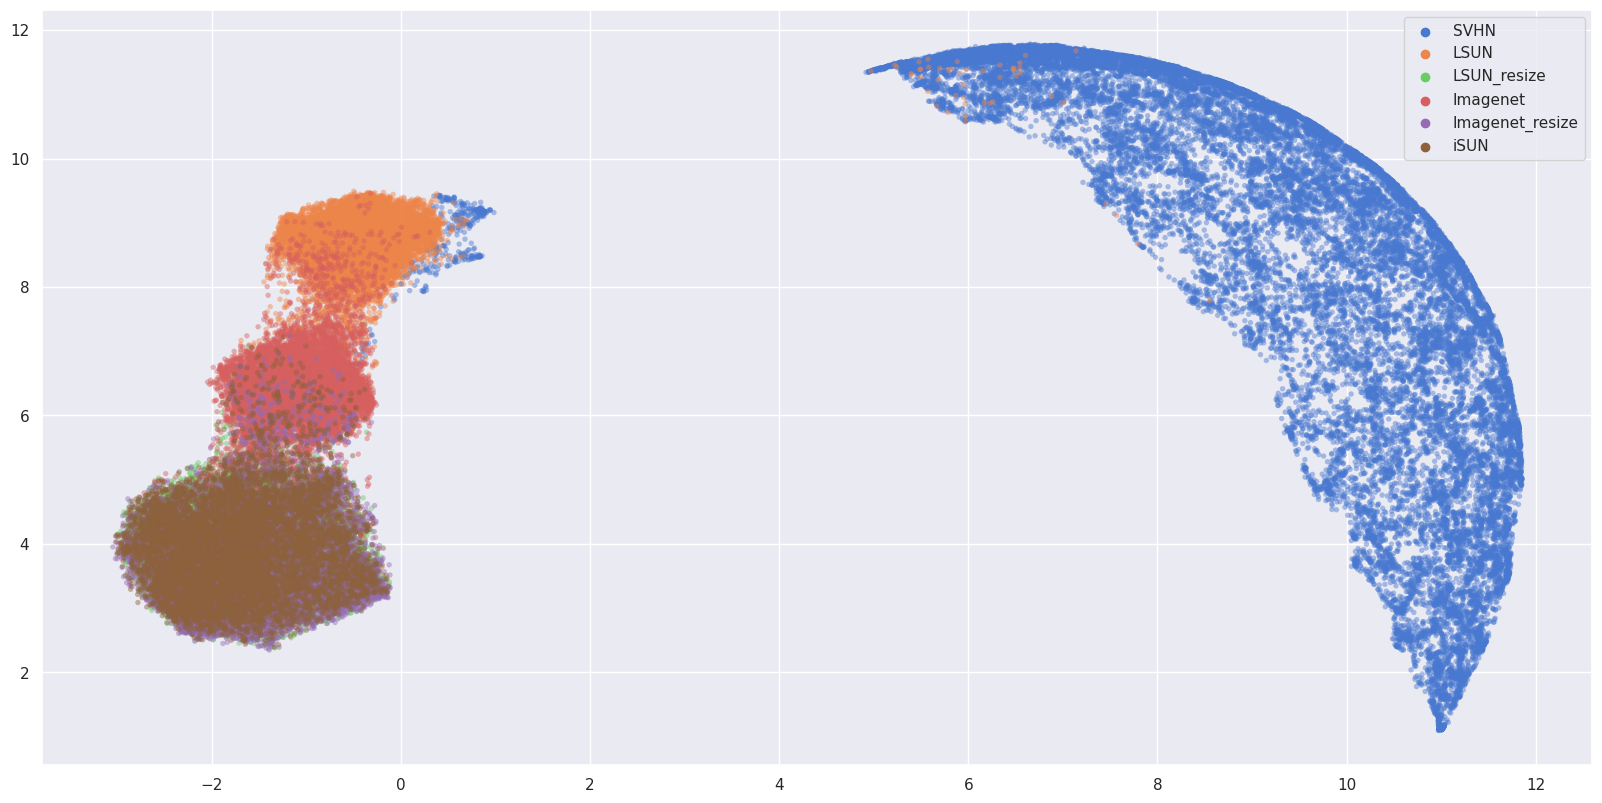

In [43]:
plot_embedding(embedding, all_labels, captions)

# Auxiliary model analysis

In [15]:
# Train Data = L2-norm(Pixel Scores)
X_train, X_test =  train_scores.copy(), inlier_scores.copy()

========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   16.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  2.8min finished


Best: 5.796093 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
---------------------------------------------------------------------------
5.317204 (0.034164) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
5.543916 (0.033187) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
5.656083 (0.034174) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
5.692531 (0.034049) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
5.715880 (0.032516) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
5.745923 (0.032561) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
5.760441 (0.031139) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
5.779768 (0.033457) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
5.788104 (0.029205) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
5.796093 (0.029358) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


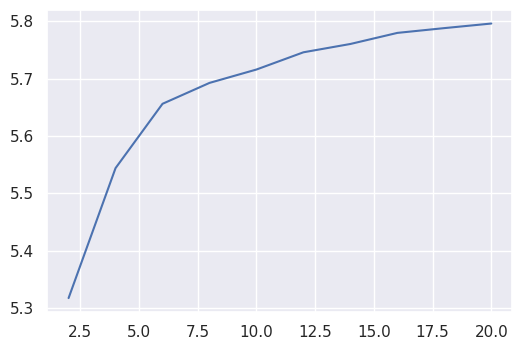

---Likelihoods---
Training: 5.817
SVHN: 5.428
LSUN: -2096.576
LSUN_resize: -1153.359
Imagenet: -1568.825
Imagenet_resize: -1912.020
iSUN: -1659.023
Gaussian: -2500.622
Uniform: -1165.786
CIFAR: -6.732
All Images: -1678.377
========================= Training Flow Model =========================
Epoch 1/1000
570/570 [==============================] - 2s 3ms/step - loss: 1980.9292 - val_loss: 771.5512
Epoch 2/1000
570/570 [==============================] - 2s 3ms/step - loss: 556.5962 - val_loss: 364.3036
Epoch 3/1000
570/570 [==============================] - 2s 3ms/step - loss: 317.1392 - val_loss: 246.4451
Epoch 4/1000
570/570 [==============================] - 2s 3ms/step - loss: 234.3237 - val_loss: 197.3783
Epoch 5/1000
570/570 [==============================] - 2s 3ms/step - loss: 204.6085 - val_loss: 182.3178
Epoch 6/1000
570/570 [==============================] - 2s 3ms/step - loss: 191.2421 - val_loss: 171.8169
Epoch 7/1000
570/570 [==============================] - 2s 3ms/step 

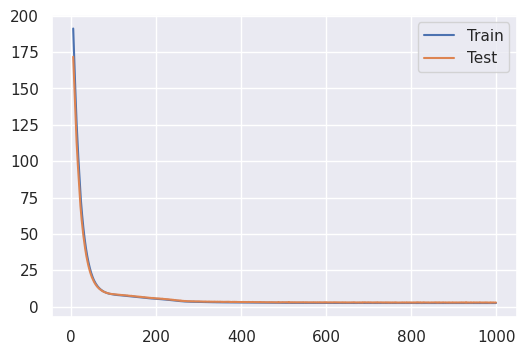

========================= Training KD Tree =========================
CPU times: user 1h 36min 55s, sys: 37min 9s, total: 2h 14min 5s
Wall time: 32min 12s


In [16]:
%%time
results = auxiliary_model_analysis(X_train, X_test, outlier_scores, LABELS, flow_epochs=1000)

In [21]:
TEST_IDX=7

## GMM

In [22]:
results["GMM"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
LSUN,0.000000,0.003846,99.999999,99.999998,100.000000,0.000000,99.999998
LSUN_resize,0.000000,0.005769,99.999997,99.999993,99.999999,0.000000,99.999993
Imagenet,0.000000,0.010769,99.999995,99.999986,99.999998,0.000000,99.999986
Imagenet_resize,0.000000,0.001923,100.000000,99.999999,100.000000,0.000000,99.999999
iSUN,0.000000,0.003846,99.999997,99.999991,99.999999,0.000000,99.999991
Gaussian,0.000000,0.000000,100.000000,100.000000,100.000000,0.000000,100.000000
Uniform,0.000000,0.000000,100.000000,100.000000,100.000000,0.000000,100.000000
CIFAR,9.319231,7.121154,97.623387,92.475424,99.152342,3.261538,92.476874
All Images,0.000000,0.006791,99.999998,99.999999,99.999995,0.000000,99.999999


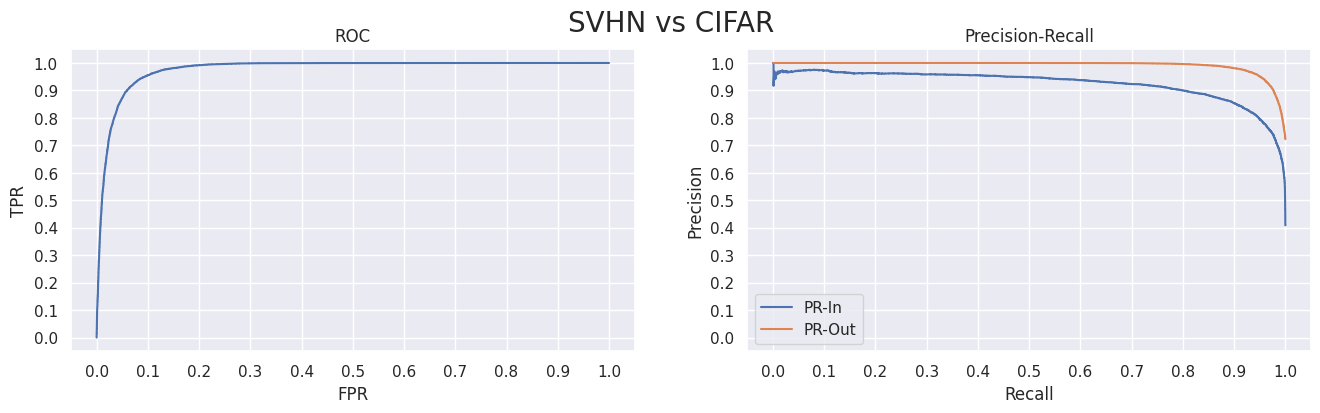

SVHN vs CIFAR
----------------
ROC-AUC: 97.6234
PR-AUC (In/Out): 92.4754 / 99.1523
FPR (95% TPR): 9.32%
Detection Error: 7.12%


{'fpr_tpr95': 0.09319230769230769,
 'de': 0.07121153846153849,
 'roc_auc': 0.9762338730769231,
 'pr_auc_in': 0.9247542385043235,
 'pr_auc_out': 0.9915234240983071,
 'fpr_tpr80': 0.032615384615384616,
 'ap': 0.9247687444914923}

In [23]:
ood_metrics(-results["GMM"]["test_scores"], -results["GMM"]["ood_scores"][TEST_IDX], names=(LABELS[1], LABELS[TEST_IDX+2]), plot=True, verbose=True)

### Validation Check

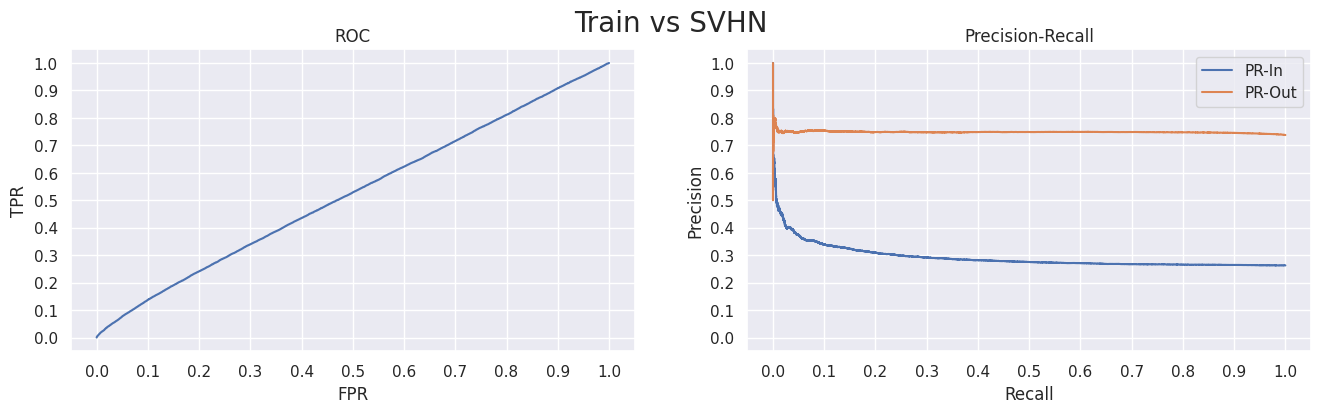

Train vs SVHN
----------------
ROC-AUC: 52.4482
PR-AUC (In/Out): 29.1965 / 74.8164
FPR (95% TPR): 94.58%
Detection Error: 47.89%


{'fpr_tpr95': 0.9457808219178082,
 'de': 0.4789478398314015,
 'roc_auc': 0.5244815105374078,
 'pr_auc_in': 0.29196489097962597,
 'pr_auc_out': 0.7481639314799645,
 'fpr_tpr80': 0.7781369863013698,
 'ap': 0.29200281147221196}

In [24]:
ood_metrics(-results["GMM"]["train_scores"], -results["GMM"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## Flow Models

In [25]:
results["Flow"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
LSUN,0.000000,0.066154,99.999452,99.998571,99.999790,0.0,99.998571
LSUN_resize,0.000000,0.069615,99.998763,99.996749,99.999528,0.0,99.996749
Imagenet,0.000000,0.073462,99.999290,99.998145,99.999728,0.0,99.998145
Imagenet_resize,0.000000,0.061154,99.999489,99.998665,99.999804,0.0,99.998665
iSUN,0.000000,0.082191,99.999217,99.997709,99.999733,0.0,99.997709
Gaussian,0.000000,0.000000,100.000000,100.000000,100.000000,0.0,100.000000
Uniform,0.000000,0.000000,100.000000,100.000000,100.000000,0.0,100.000000
CIFAR,10.584615,7.818462,96.903987,88.193601,98.918565,4.0,88.201292
All Images,0.000000,0.074582,99.999243,99.999595,99.998612,0.0,99.999595


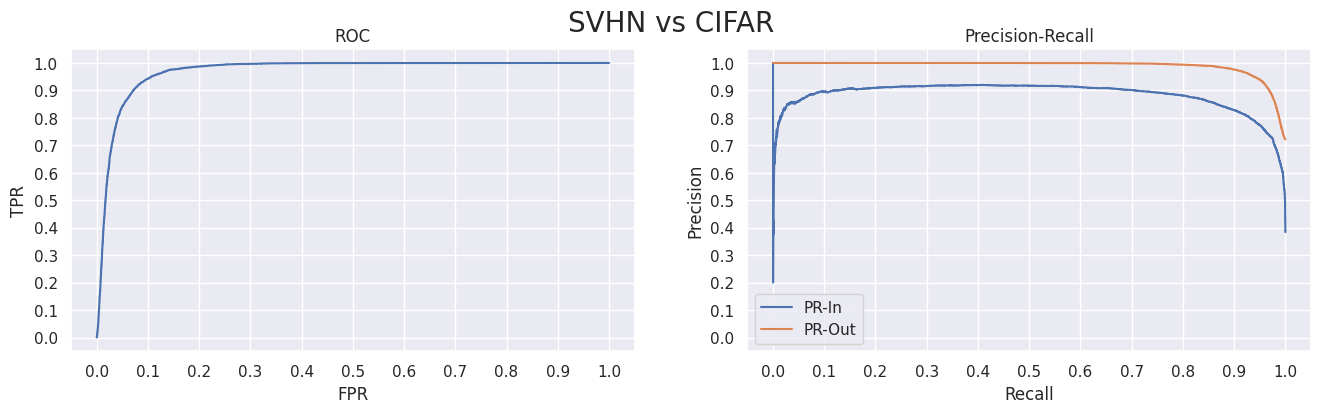

SVHN vs CIFAR
----------------
ROC-AUC: 96.9040
PR-AUC (In/Out): 88.1936 / 98.9186
FPR (95% TPR): 10.58%
Detection Error: 7.82%


{'fpr_tpr95': 0.10584615384615384,
 'de': 0.07818461538461538,
 'roc_auc': 0.969039869230769,
 'pr_auc_in': 0.8819360112194237,
 'pr_auc_out': 0.9891856495196182,
 'fpr_tpr80': 0.04,
 'ap': 0.8820129180867023}

In [26]:
ood_metrics(-results["Flow"]["test_scores"], -results["Flow"]["ood_scores"][TEST_IDX], names=(LABELS[1], LABELS[TEST_IDX+2]), plot=True, verbose=True)

### Validation Check

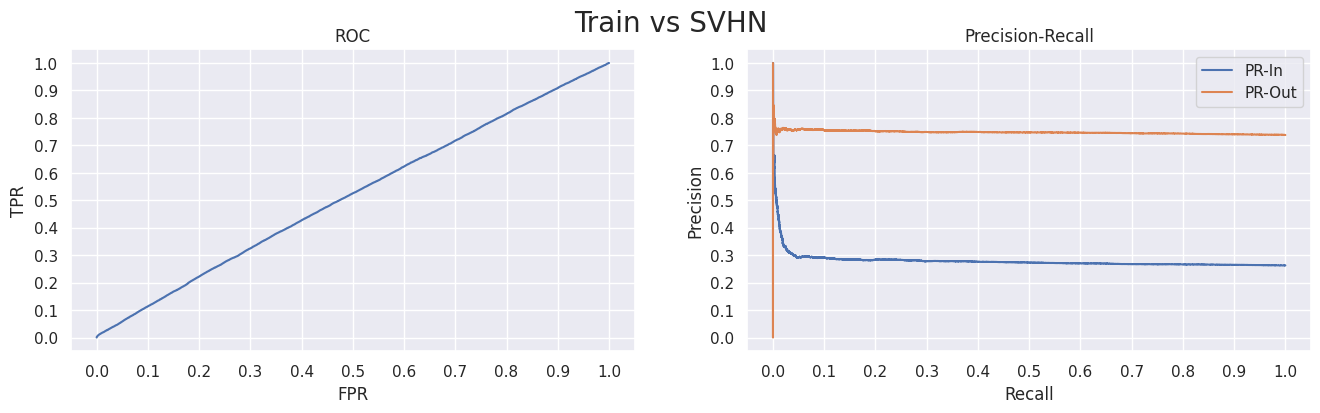

Train vs SVHN
----------------
ROC-AUC: 51.7905
PR-AUC (In/Out): 27.9086 / 74.7455
FPR (95% TPR): 94.26%
Detection Error: 48.59%


{'fpr_tpr95': 0.9425616438356165,
 'de': 0.485913856691254,
 'roc_auc': 0.5179052207586934,
 'pr_auc_in': 0.27908615901114525,
 'pr_auc_out': 0.7474546367983235,
 'fpr_tpr80': 0.7750410958904109,
 'ap': 0.2791186454548158}

In [27]:
ood_metrics(-results["Flow"]["train_scores"], -results["Flow"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## KD Trees w/ k=5

In [28]:
results["KD"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
LSUN,0.042308,0.180385,99.992892,99.980165,99.997394,0.003846,99.980166
LSUN_resize,0.038462,0.108462,99.992515,99.978230,99.997317,0.011538,99.978232
Imagenet,0.046154,0.181538,99.990725,99.973260,99.996658,0.011538,99.973261
Imagenet_resize,0.011538,0.075769,99.998252,99.995329,99.999341,0.000000,99.995330
iSUN,0.023077,0.081857,99.996701,99.989862,99.998905,0.000000,99.989863
Gaussian,0.000000,0.000000,100.000000,100.000000,100.000000,0.000000,100.000000
Uniform,0.000000,0.000000,100.000000,100.000000,100.000000,0.000000,100.000000
CIFAR,8.469231,6.624231,97.630403,92.543656,99.155333,3.476923,92.544555
All Images,0.034615,0.146286,99.994163,99.996665,99.991043,0.003846,99.996665


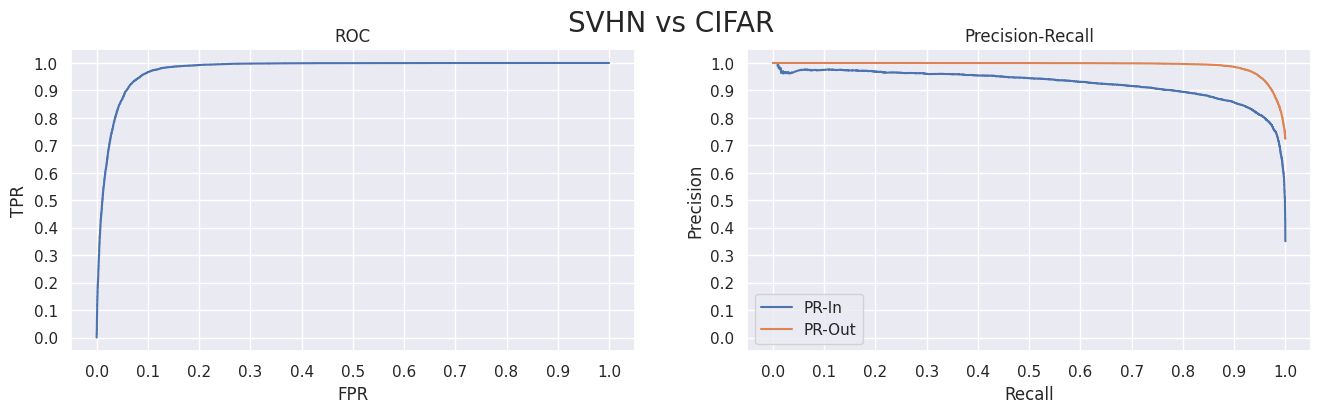

SVHN vs CIFAR
----------------
ROC-AUC: 97.6304
PR-AUC (In/Out): 92.5437 / 99.1553
FPR (95% TPR): 8.47%
Detection Error: 6.62%


{'fpr_tpr95': 0.08469230769230769,
 'de': 0.06624230769230771,
 'roc_auc': 0.976304026923077,
 'pr_auc_in': 0.9254365561295721,
 'pr_auc_out': 0.9915533339796203,
 'fpr_tpr80': 0.03476923076923077,
 'ap': 0.9254455498070387}

In [29]:
ood_metrics(results["KD"]["test_scores"], results["KD"]["ood_scores"][TEST_IDX], names=(LABELS[1], LABELS[TEST_IDX+2]), plot=True, verbose=True)

### Validation Check

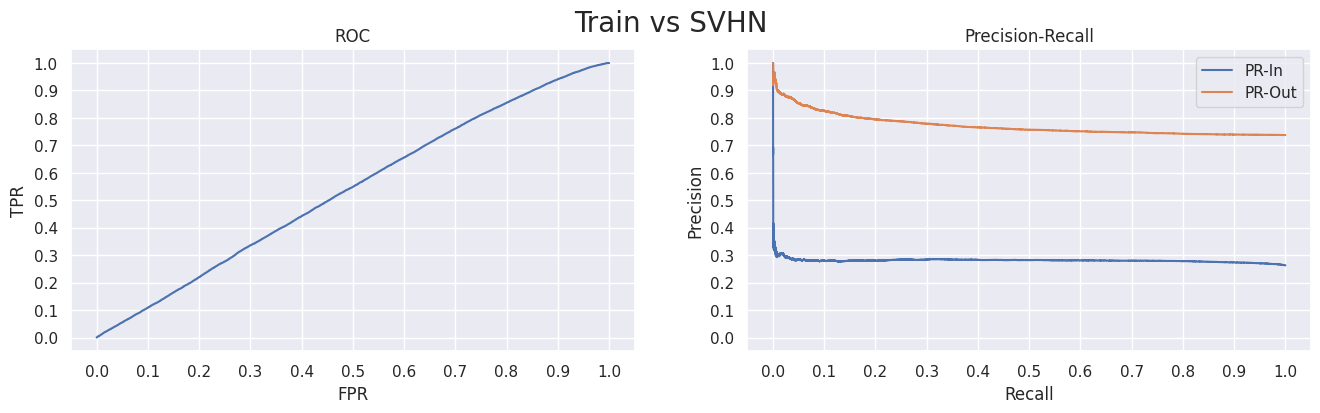

Train vs SVHN
----------------
ROC-AUC: 53.7531
PR-AUC (In/Out): 28.0684 / 77.1672
FPR (95% TPR): 91.20%
Detection Error: 46.90%


{'fpr_tpr95': 0.911958904109589,
 'de': 0.46897971548998946,
 'roc_auc': 0.5375311907270811,
 'pr_auc_in': 0.28068418639709664,
 'pr_auc_out': 0.7716721617266211,
 'fpr_tpr80': 0.7294931506849315,
 'ap': 0.28072060472015}

In [30]:
ood_metrics(results["KD"]["train_scores"], results["KD"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## GMM vs Flow vs K-NN Tree

GMM ...
SVHN vs All
----------------
ROC-AUC: 99.6989
PR-AUC (In/Out): 99.9010 / 99.1523
FPR (95% TPR): 1.52%
Detection Error: 2.90%

Flow Model ...
SVHN vs All
----------------
ROC-AUC: 99.6073
PR-AUC (In/Out): 99.8703 / 98.9178
FPR (95% TPR): 2.20%
Detection Error: 3.31%

KD Tree ...
SVHN vs All
----------------
ROC-AUC: 99.6961
PR-AUC (In/Out): 99.8998 / 99.1503
FPR (95% TPR): 1.69%
Detection Error: 3.05%



Text(0.5, 0.98, 'Comparing Auxiliary Methods')

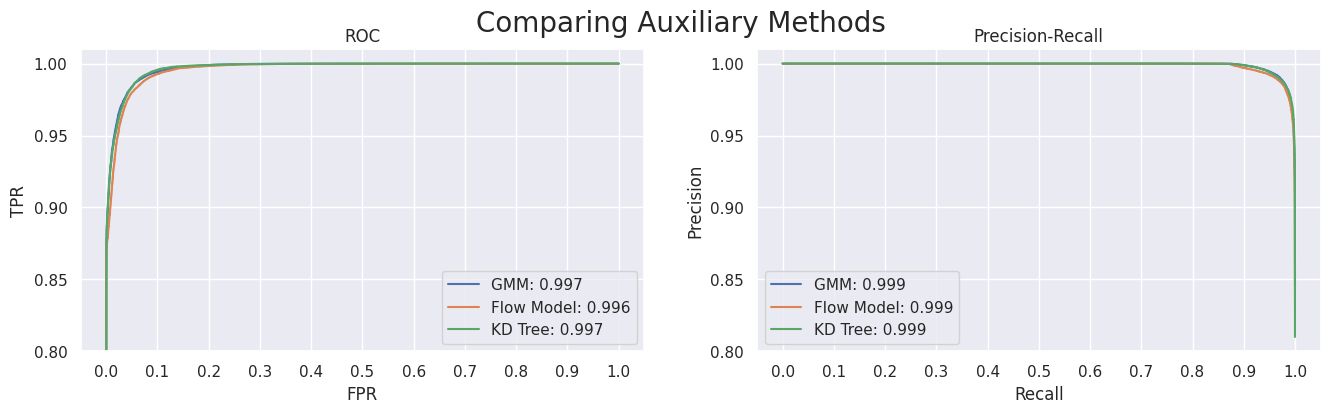

In [34]:
gmm_all = np.concatenate(-results["GMM"]["ood_scores"][:-1])
flow_all = np.concatenate(-results["Flow"]["ood_scores"][:-1])
kd_all = np.concatenate(results["KD"]["ood_scores"][:-1])

pairs = zip(
    ["GMM", "Flow Model", "KD Tree"],
    [-results["GMM"]["test_scores"], -results["Flow"]["test_scores"], results["KD"]["test_scores"]],
    [gmm_all, flow_all, kd_all]
)

fig, axs = plt.subplots(1,2, figsize=(16,4))

for title, cifar_scores, svhn_scores in pairs:
    print(title, "...")
    ood_metrics(cifar_scores, svhn_scores, names=("SVHN", "All"),plot=False, verbose=True)
    plot_curves(cifar_scores, svhn_scores, title, axs)
    print()

for ax in axs:
    ax.set(ylim=(0.8, 1.01), yticks=np.arange(0.8, 1.01, step=0.05))
axs[1].set(ylim=(0.8, 1.01))

plt.suptitle("Comparing Auxiliary Methods",  fontsize=20)
# plt.savefig("../../Figures/aux.png", dpi=200)